In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
#import scipy.special as spsp
#import time

In [2]:
# https://github.com/XanaduAI/thewalrus/blob/master/thewalrus/_permanent.py

@jit(nopython=True)
def perm_bbfg(M):  # pragma: no cover
    """
    Returns the permanent of a matrix using the bbfg formula in Gray ordering
    The code is a re-implementation from a Python 2 code found in
    `Permanent code golf
    <https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible>`_
    using Numba.
    Args:
        M (array) : a square array.
    Returns:
        float or complex: the permanent of a matrix ``M``
    """

    n = len(M)
    if n == 0:
        return M.dtype.type(1.0)
    row_comb = np.sum(M, 0)
    total = 0
    old_gray = 0
    sign = +1
    binary_power_dict = np.array([2**i for i in range(n)])
    num_loops = 2 ** (n - 1)
    for bin_index in range(1, num_loops + 1):
        reduced = np.prod(row_comb)
        total += sign * reduced
        new_gray = bin_index ^ (bin_index // 2)
        gray_diff = old_gray ^ new_gray
        gray_diff_index = np.searchsorted(binary_power_dict,gray_diff)
        new_vector = M[gray_diff_index]
        direction = 2 * ((old_gray > new_gray) - (old_gray < new_gray))
        for i in range(n):
            row_comb[i] += new_vector[i] * direction
        sign = -sign
        old_gray = new_gray
    return total / num_loops

In [3]:
@jit(nopython=True)
def calc_z(L,L_A,tstep):
#    x = np.zeros((L,L), dtype = np.float64)
    x = np.zeros((L,L), dtype = np.complex128)
    for j in range(L):
        for k in range(L):
            x[j,k] = np.sin((j+1)*(k+1)*np.pi / (L+1))
    x *= np.sqrt(2.0 / (L+1))
    eps = np.array([-2.0 * np.cos((n+1) * np.pi / (L+1)) for n in range(L)])
    #
    ## y by definition
    y = x @ (np.diag(np.exp(1j * eps * tstep))) @ x
    ## y for thermodynamic limit
#    y_inf = np.zeros((L,L), dtype = np.complex128)
#    for j in range(L):
#        for k in range(L):
#            y_sub = (-1j)**(j-k) * (spsp.jn(j-k, 2.0 * tstep) + (-1)**(k) * spsp.jn(j+k+2, 2.0 * tstep))
#            y_inf[j,k] = y_sub
    z = np.zeros((L,L), dtype = np.complex128)
    for j in range(L):
        for k in range(L):
            for m in range(L_A):
                z[j,k] += y[j,m].conjugate() * y[k,m]
    ## z for thermodynamic limit
#    z_inf = np.zeros((L,L), dtype = np.complex128)
#    for j in range(L):
#        for k in range(L):
#            for m in range(L_A):
#                # z_inf[j,k] += y_inf[j,m].conjugate() * y_inf[k,m]
#                z_inf[j,k] += (-1)**(k+1) * (+1j)**(j+k+2) * (spsp.jn(j-m, 2.0 * tstep) + (-1)**(m) * spsp.jn(j+m+2, 2.0 * tstep)) \
#                    * (spsp.jn(k-m, 2.0 * tstep) + (-1)**(m) * spsp.jn(k+m+2, 2.0 * tstep))
    #
#    dlt = np.identity(L,dtype=np.float64)
    dlt = np.eye(L,dtype=np.complex128)
    matz = np.vstack( (np.hstack((z,dlt-z)), np.hstack((dlt-z,z))) )
#    return matz, z, z_inf
    return matz, z

In [4]:
#L = 8
#L_A = L//2
#ts = np.linspace(0,20,201)
#data = []
#for tstep in ts:
#    #matz, z, z_inf = calc_z(L,L_A,tstep)
#    matz, z = calc_z(L,L_A,tstep)
#    #print(tstep,-np.log(perm_bbfg(matz).real))
#    data.append([tstep,-np.log(perm_bbfg(matz).real)])
#data = np.array(data)
#
#plt.plot(data[:,0],data[:,1]*2)

In [5]:
print("# L time max(z_diag) min(z_diag) max(z_offdiag)")
#Ls = [2**i for i in range(4,12)]
Ls = [i for i in range(64,1024+64,64)]
data = []
for L in Ls:
    L_A = L//2
    #ts = [L//4]
    #ts = [8*L]
    ts = [1024*L]
    for tstep in ts:
        #matz, z, z_inf = calc_z(L,L_A,tstep)
        matz, z = calc_z(L,L_A,tstep)
        flag_offdiag = ~np.eye(z.shape[0],dtype=bool)
        #print(flag_offdiag)
        print(L, tstep, np.max(np.abs(np.diag(z))), np.min(np.abs(np.diag(z))), np.max(np.abs(z[flag_offdiag])) )
        data.append([L, tstep, np.max(np.abs(np.diag(z))), np.min(np.abs(np.diag(z))), np.max(np.abs(z[flag_offdiag])) ])
data = np.array(data)

# L time max(z_diag) min(z_diag) max(z_offdiag)
64 65536 0.6909825923720784 0.3090174076279214 0.22056948826596656
128 131072 0.672781353523123 0.3272186464768776 0.19295365027601835
192 196608 0.6137207708701263 0.3862792291298705 0.16199843628895194
256 262144 0.6067106670911435 0.393289332908857 0.1607182962198606
320 327680 0.608016514155238 0.39198348584476167 0.13084660801516856
384 393216 0.599365591937611 0.4006344080623909 0.11654527355055475
448 458752 0.5896064764438245 0.4103935235561791 0.11685572341884236
512 524288 0.586745480430494 0.4132545195695069 0.09497258451264035
576 589824 0.5658382092715819 0.4341617907284186 0.11293945228272183
640 655360 0.5969173464509248 0.4030826535490709 0.10914505690983504
704 720896 0.5787636173084413 0.42123638269155816 0.11833350705581322
768 786432 0.5629979337882198 0.4370020662117793 0.09179085725754957
832 851968 0.5739172420995343 0.4260827579004693 0.08610876393699521
896 917504 0.5555434273282553 0.4444565726717518 0.0940825510

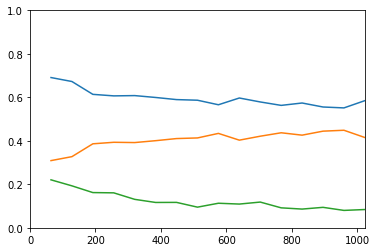

In [6]:
plt.xlim(0,np.max(Ls))
plt.ylim(0,1)
plt.plot(data[:,0],data[:,2])
plt.plot(data[:,0],data[:,3])
plt.plot(data[:,0],data[:,4])
plt.show()
plt.close()